# Vergleich zweier Filter

In [1]:
import numpy as np
import tensorflow as tf
import model_cnn
import preprocessing_classification as pre_c
np.set_printoptions(threshold=np.nan)
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import os, glob
import scattertext as st
import spacy
from pprint import pprint
nlp = spacy.load('de_core_news_sm')

In [2]:
sess = tf.InteractiveSession()

text_length = 1000
num_authors = 5
input_cnn = tf.placeholder(tf.float32, [None, len(pre_c.alphabet), text_length, 1], name="input_x")
with tf.variable_scope("cnn"):
    cnn_logits, cnn_variables, _ = model_cnn.inference(
            input_x=input_cnn, keep_prob=1.0, num_authors=num_authors)
known_vars = []
known_vars = tf.global_variables()
saver = tf.train.Saver(var_list=known_vars)
saver.restore(sess, "../resources/1511967049/saves/cnn.ckpt-00009384")
print("cnn_classifier restored")

INFO:tensorflow:Restoring parameters from ../resources/1511967049/saves/cnn.ckpt-00009384
cnn_classifier restored


In [3]:
w_1 = sess.run('cnn/conv-maxpool-1/W:0')
b_1 = sess.run('cnn/conv-maxpool-1/b:0')
w_2 = sess.run('cnn/conv-maxpool-2/W:0')
b_2 = sess.run('cnn/conv-maxpool-2/b:0')
w_3 = sess.run('cnn/conv-3/W:0')
b_3 = sess.run('cnn/conv-3/b:0')
w_4 = sess.run('cnn/conv-4/W:0')
b_4 = sess.run('cnn/conv-4/b:0')
w_5 = sess.run('cnn/conv-5/W:0')
b_5 = sess.run('cnn/conv-5/b:0')
w_6 = sess.run('cnn/conv-maxpool-6/W:0')
b_6 = sess.run('cnn/conv-maxpool-6/b:0')
w_fc = sess.run('cnn/fc/W-fc:0')
b_fc = sess.run('cnn/fc/b-fc:0')
weights = [w_1, w_2, w_3, w_4, w_5, w_6, w_fc]
biases = [b_1, b_2, b_3, b_4, b_5, b_6, b_fc]

In [4]:
for wi,w in enumerate(weights):
    weights[wi] = np.squeeze(w)
weights[0] = np.transpose(weights[0], [1,0,2])

In [5]:
weights[-1] = np.reshape(weights[-1], [980,256,5])
for v in weights:
    print(v.shape)

(7, 70, 256)
(7, 256, 256)
(3, 256, 256)
(3, 256, 256)
(3, 256, 256)
(3, 256, 256)
(980, 256, 5)


In [6]:
biases = [np.zeros(4)] + biases
for v in biases:
    print(v.shape)

(4,)
(256,)
(256,)
(256,)
(256,)
(256,)
(256,)
(5,)


In [7]:
def get_txts(output_mat):
    txt = ''.join([pre_c.alphabet[np.argmax(v)] for v in output_mat])
    txt_list = list(txt)
    for i, _ in enumerate(txt_list):
        if np.max(output_mat[i]) > np.max(output_mat)/2:
            txt_list[i] = '_'
    txt_spaces = ''.join(txt_list)
    return txt, txt_spaces

In [8]:
layers = [input_cnn.shape[1:3][::-1]] + [v.shape[-2:] for v in cnn_variables[:-1]] + [cnn_logits.shape[1:2]]

In [9]:
# RAM-sparende Implementierung

def get_NR_matrices(start = np.array([0.0,1.0,0.0,0.0,0.0]), startlayer = 0, numlayers=100):
    NR_matrices = []
    NR_matrices.append(start)
    if startlayer < 1:
        NR_matrices.append(np.sum(weights[-1]*NR_matrices[-1], axis=2))
        if numlayers < 3:
            return NR_matrices
    
    for i in range(2+startlayer,len(layers)):
        nr_pre = np.zeros([layers[-(i+1)][0], layers[-(i+1)][1]])
        ws = np.pad(weights[-i], ((0,int(layers[-(i+1)][0]-weights[-i].shape[0])),(0,0),(0,0)), mode='constant')
        print(ws.shape)
        for k in range(NR_matrices[-1].shape[0]):
            nr_pre = np.add(nr_pre, np.sum(np.multiply(np.roll(ws, shift=k, axis=0), NR_matrices[-1][k,:]), axis=2))
        NR_matrices.append(nr_pre)
        if numlayers == i+1-startlayer:
            return NR_matrices
    return NR_matrices

In [10]:
# NR_ms = []
# for i in range(5):
#     start = np.zeros(5)
#     start[i] = 1
#     NR_ms.append(get_NR_matrices(start))

In [11]:
# for i, NR_m in enumerate(NR_ms):
#     np.savez_compressed("../resources/NeuronRank/NeuronRank_five-authors-"+str(i), layer1=NR_m[0], layer2=NR_m[1], layer3=NR_m[2], layer4=NR_m[3], layer5=NR_m[4], layer6=NR_m[5], layer7=NR_m[6], layer8=NR_m[7])

In [12]:
NR_ms = [[],[],[],[],[]]
for file in glob.glob("../resources/NeuronRank/NeuronRank_five-authors*"):
    loaded = np.load(file)
    print(loaded.keys())
    for i in range(8):
        NR_ms[int(file[-5])].append(loaded["layer"+str(i+1)])

['layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'layer6', 'layer7', 'layer8']
['layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'layer6', 'layer7', 'layer8']
['layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'layer6', 'layer7', 'layer8']
['layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'layer6', 'layer7', 'layer8']
['layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'layer6', 'layer7', 'layer8']


## Aktivierungen laden

In [13]:
activations_file_list = ["../resources/activations-five-authors/TrainSet-five_authors.txt-activations-"+str(i)+".npz" for i in range(35)]
text_file_list = ["../resources/activations-five-authors/TrainSet-five_authors.txt-texts-"+str(i)+".txt" for i in range(35)]

In [14]:
layer = 1
stack_for_filter = np.stack(arrays=[NR_ms[0][layer], NR_ms[1][layer], NR_ms[2][layer], NR_ms[3][layer], NR_ms[4][layer]], axis=0)

stack_for_filter_argsorted_layer = np.copy(stack_for_filter)
for i, layer in enumerate(stack_for_filter):
    stack_for_filter_argsorted_layer[i] = np.argsort(layer, axis=None).reshape(layer.shape)

pos_filter = [np.where(x > 0) for x in stack_for_filter]
neg_filter = [np.where(x < 0) for x in stack_for_filter]
first_quarter_filter  = [np.where(x < np.max(x[i])*0.10) for i, x in enumerate(stack_for_filter_argsorted_layer)]
fourth_quarter_filter = [np.where(x > np.max(x[i])*0.90) for i, x in enumerate(stack_for_filter_argsorted_layer)]

filter_list = [pos_filter, neg_filter, first_quarter_filter, fourth_quarter_filter]


In [15]:
means = np.zeros([1,4,5])
ac_7s = np.zeros([1,980,256])
logits = np.zeros([1,2])
texts = []
for act_file_path, txt_file_path in zip(activations_file_list, text_file_list):
    log = np.load(act_file_path)['logits']
    filt = np.where(log[:,0] == log[:,1])
    act = np.load(act_file_path)['act_7'].reshape(-1, 980, 256)[filt]
    log = log[filt]
    
    txt = np.array(open(txt_file_path).read().split('\n'))[filt][0:len(act)]
    texts += list(txt)

    ac_7s = np.append(ac_7s, act, axis=0)
    means = np.append(means, np.array([[[np.mean(a[f[f_i]]) for f_i in range(5)] for f in filter_list] for a in act]), axis=0)
    logits = np.append(logits, log, axis=0)
ac_7s = ac_7s[1:,:,:]
means = means[1:,:,:]
logits = logits[1:,:]

## Filter 42

In [16]:
argsorted_for_42 = np.argsort(ac_7s, axis=0)

In [17]:
texte_42_nach_autor = [[],[],[],[],[]]
for x in argsorted_for_42[-5:,:,42]:
    for start_i, sample_i in enumerate(x):
        print(str(int(logits[sample_i][0]))+"\t"+texts[sample_i][start_i:start_i+22])
        texte_42_nach_autor[int(logits[sample_i][0])].append(texts[sample_i][start_i:start_i+22])

1	a sowohl, als seine Fr
1	plündernd, ein silbern
1	bedurfte, als Einsicht
2	ten Wände, in diese hö
1	machen sollte, ein Zei
3	eggio tranken, sagte m
3	en Anstand, seine Unzu
1	rafen wollte, gibt ihr
4	ossen bin, dies, sowei
1	Wunde, die er, zu Anfa
3	hm, so, so, der alte H
1	leidern, die sie schne
4	letzte, kleinste, vers
0	wort erhalten, es seie
4	rumgehen, mit ihnen sp
1	nd hilflos, in der Mit
3	n Rom, in Athen, in Wi
0	asten, Wachen, Einsamk
0	 für ratsam, sie aus d
1	setzen wolle, ihn aus 
4	nnen von ihm, die Freu
1	rte, daß sie, in diese
4	nahende Alter, einen s
4	ahende Alter, einen so
3	mkopf hielten, saß er 
1	ute vor, daß sie in ih
3	zureden hätte, so schi
1	ürt hatte, mit einem H
1	ffend, etwas, das ihm 
4	teilhaft, dieses eine 
1	ist; geh, Herse, geh z
0	tteilte, die, wie Sie 
3	ges, überließ, dieselb
0	eilte, die, wie Sie wi
3	tufe stellt, sie auf d
1	m hatte Elvire, in ein
2	s Äcker, Wiesen, Baumg
1	, wenn er, in der heut
3	ragte: »Louis, hat mei
1	 Himmel, diese deine E


1	higen wolle, mit ferne
1	er Fremde aß, in sein 
1	e Pferde, die er in de
1	 uns das Tier, diesem 
1	gehen sollte, nicht vo
1	n an Paolo, ihren klei
2	hönen Frau, sie schein
1	 sein sollte, bei dem 
1	uklagen, er, heiteren 
1	er dem Arm, so, daß es
1	sie den Brief, den ihr
1	milie, die er, unter d
1	zu wenden, indem, wenn
1	nähren sollte, sind di
2	t wir wollten, in dem 
1	erwiderte, indem er mi
1	selbe, dem, bei seiner
1	 und zog, als sämtlich
1	lbe, dem, bei seiner A
1	n Tronka, als dem allg
1	e Mutter, als sie von 
2	 weiß wohl, es ist ihr
3	: »Bravo, alter Herr. 
1	 wiederholte, und, auf
0	sung hatte, eine reich
1	ten hatte, in sein Zim
1	ederholte, und, auf sc
2	 und Flavio, Ihre gute
0	inander, ihm Dienste a
1	en warf, sagte, entsch
4	rhandeln, sei dein ein
1	 Himboldt, sein Vetter
1	da dieser, in eben die
1	her sowohl, als auch d
3	ch einfiel, daß er nur
0	 die andre, ein Fest d
1	 sein konnte, befunden
1	 Tor jagte, rief, um d
1	lüpfen wollte, ein Tru
1	er Kosten, in den Stäl


1	 aufloderte, einer der
2	machen sollte, seine l
1	ehmen wollten, verblic
1	 Rührung, die sie nich
1	be. Die Alte, nach ein
1	eigerufen, in dem Gema
1	teste war, indem sie d
1	 er Gustav, seinem Vet
1	roß wären, ihn, um sei
1	e Granate, die, eben i
1	hlhaas, der, in eben d
0	bringen, oder, was ebe
1	ranate, die, eben in d
1	d, dem Volk, das sie u
1	s sowohl, als ihrer Mu
0	gen, oder, was ebensov
2	rachtete, mit einem kl
1	 und das ihm, dem Alte
1	und rief ihn, seinen s
2	n Freund«, versetzte d
1	h von Trota, sein Kämm
1	r sowohl, als ihres Fr
2	em Grunde, indem sie s
0	 Vorwürfe, ihren Strei
1	; Rudolf, vor Entrüstu
1	innen wollte, bis wir,
1	den ist, du, dessen gr
1	auf den Brief, den er 
1	Kohlhaas, als er, mit 
1	en werde, ihm einen Wa
2	künstler, der, wenn er
1	 Harmlos, ohne Elviren
0	e Ihrige, auf, meine W
1	olgt, wollte, daß Piac
2	 Schritten, in sich ge
1	eln sollte, dessen Blu
1	ahren, der ihn, als ei
1	auswindend, rief er de
1	ragte Toni, indem sie 
0	ttern wollte, erstarb 


In [18]:
author_names = ["Goethe", "Kafka", "Kleist", "Raabe", "Schiller"]
with open('filter-comparison-files/texte_42.csv', mode='w') as csv:
    csv.write("kafka,author,text\n")
    for i in range(5):
        for text in texte_42_nach_autor[i]:
            csv.write(str(i==1)+"_,"+author_names[i]+',"'+text+'"\n')

In [19]:
text_df = pd.read_csv('filter-comparison-files/texte_42.csv',sep=',',quotechar='"')

In [20]:
corpus = st.CorpusFromPandas(text_df, category_col='kafka', text_col='text', nlp=nlp).build()

In [21]:
html = st.produce_scattertext_explorer(corpus=corpus,category='True_',category_name='True_',not_category_name='False_',width_in_pixels=1000,metadata=text_df['author'])

In [22]:
open("filter-comparison-files/filt_42-Visualization.html", 'wb').write(html.encode('utf-8'))

637374

## Filter 152

In [23]:
argsorted_for_152 = np.argsort(ac_7s, axis=0)

In [24]:
texte_152_nach_autor = [[],[],[],[],[]]
for x in argsorted_for_152[-5:,:,152]:
    for start_i, sample_i in enumerate(x):
        print(str(int(logits[sample_i][0]))+"\t"+texts[sample_i][start_i:start_i+22])
        texte_152_nach_autor[int(logits[sample_i][0])].append(texts[sample_i][start_i:start_i+22])

0	ster Prinz. Vielleicht
0	 aber der Prinz ist ih
0	n den Prinzen. Ich bem
0	llte dem Prinzen diese
0	in des Prinzen Leben. 
0	en war. Der Prinz ents
0	euerster Prinz!« »Der 
0	 des Prinzen Namen auf
0	k des Prinzen machte A
0	nd dem Prinzen. Das ga
0	 an dem Prinzen, die e
0	an dem Prinzen, die er
0	n dem Prinzen, die er 
0	nd auf des Prinzen Sti
0	er Treppe. »Wie gut wa
0	ferkeit u.s.f. in eine
0	nädigster Prinz,« rief
0	lieren. Der Prinz, des
0	ieren. Der Prinz, dess
0	an dem Prinzen gelegen
0	n dem Prinzen gelegen 
0	en. Der Prinz, dessen 
3	Mittag!«... Wie nichts
3	ittag!«... Wie nichts 
0	, den Prinzen von sein
0	ich der Prinz? Konnte 
0	rief der Prinz, »wen S
0	sich zum Prinzen. »Gnä
0	n. Der Prinz erwartet 
0	. Der Prinz erwartet n
0	 dem Prinzen. »Haben S
0	 Name des Prinzen hatt
0	zum Prinzen. »Gnädigst
0	ls er den Prinzen ansi
1	fen, dem Prinzen Fried
1	en, dem Prinzen Friedr
0	bei dem Prinzen in Die
0	ei dem Prinzen in Dien
0	e dem Prinzen einen gu
0	hallt. Der Prinz, unbe


1	mit dem Prinzen Friedr
0	ädigster Prinz,« rief 
0	digster Prinz,« rief i
0	igster Prinz,« rief ic
1	dem Prinzen Friedrich 
0	n von dem Prinzen von 
0	itdem der Prinz einer 
0	e?« Der Prinz trat mit
0	?« Der Prinz trat mit 
0	gewesen. Der Prinz bea
0	ie es dem Prinzen unmö
0	n, und der Prinz nur n
0	n ich den Prinzen ließ
0	es dem Prinzen unmögli
0	s dem Prinzen unmöglic
0	n. Der Prinz beantwort
0	ehme.« Der Prinz legte
0	 und der Prinz hatte s
0	n. Dem Prinzen dank' i
0	 des Prinzen waren unt
3	n  Die Prinzessin Fisc
0	führen. Der Prinz von 
0	ühren. Der Prinz von *
0	e der Prinz. »Von ihre
0	en den Prinzen sorgfäl
0	ollte. Der Prinz bemer
1	kunft der Prinz von Me
0	ürde dem Prinzen auch 
0	rde dem Prinzen auch n
0	ng des Prinzen mit dem
0	ädigster Prinz –« »Als
0	 den Prinzen zu zerstr
0	haft des Prinzen, dess
0	tor. – Der Prinz lag o
0	rm des Prinzen; sein B
0	und der Prinz war so g
0	uch der Prinz forderte
0	d der Prinz war so gef
0	hten den Prinzen. Ich 
0	är des Prinzen aufgesc


0	n?« »Der Prinz ist nic
0	weil der Prinz über di
0	eil der Prinz über die
0	hen. Der Prinz von **d
0	tehe dem Prinzen jeden
0	el, den Prinzen von se
1	 von dem Prinzen Chris
1	von dem Prinzen Christ
0	eben. Der Prinz erwart
0	ben. Der Prinz erwarte
0	en. Der Prinz erwartet
0	ich zum Prinzen. »Gnäd
0	ch zum Prinzen. »Gnädi
1	n der H... A... die Pf
1	 der H... A... die Pfe
1	der H... A... die Pfer
1	er H... A... die Pferd
0	s er den Prinzen ansic
0	 er den Prinzen ansich
0	ten. Der Prinz sprang 
0	en. Der Prinz sprang a
0	n. Der Prinz sprang an
0	men des Prinzen. Die A
0	emüt des Prinzen eine 
0	llt. Der Prinz, unbewa
0	daß dem Prinzen von al
0	aß dem Prinzen von all
0	h in dem Prinzen zu er
0	 in dem Prinzen zu erw
1	fe, den Prinzen, unfäh
0	l es dem Prinzen im »M
0	 es dem Prinzen im »Mo
0	es dem Prinzen im »Moh
0	ädigster Prinz – – Ich
0	ollte der Prinz verdop
0	llte der Prinz verdopp
0	lte der Prinz verdoppe
0	cht. Des Prinzen Unged
0	rief der Prinz. »Was h
0	ief der Prinz. »Was ha


In [25]:
author_names = ["Goethe", "Kafka", "Kleist", "Raabe", "Schiller"]
with open('filter-comparison-files/texte_152.csv', mode='w') as csv:
    csv.write("goethe,author,text\n")
    for i in range(5):
        for text in texte_152_nach_autor[i]:
            csv.write(str(i==0)+"_,"+author_names[i]+',"'+text+'"\n')

In [26]:
text_df = pd.read_csv('filter-comparison-files/texte_152.csv',sep=',',quotechar='"')

In [27]:
corpus = st.CorpusFromPandas(text_df, category_col='goethe', text_col='text', nlp=nlp).build()

In [28]:
html = st.produce_scattertext_explorer(corpus=corpus,category='True_',category_name='True_',not_category_name='False_',width_in_pixels=1000,metadata=text_df['author'])

In [29]:
open("filter-comparison-files/filt_152-Visualization.html", 'wb').write(html.encode('utf-8'))

576286

## Vergleich der Filter mit Scattertext

In [30]:
!awk -v FS=',' -v OFS='' 'BEGIN {print "filt_42,filt,text"} NR > 1 {$1=""; $2=""; print "TRUE_,_42,",$0}' 'filter-comparison-files/texte_42.csv' > 'filter-comparison-files/texte_gesamt.csv'
!awk -v FS=',' -v OFS='' 'NR > 1 {$1=""; $2=""; print "FALSE_,_152,",$0}' 'filter-comparison-files/texte_152.csv' >> 'filter-comparison-files/texte_gesamt.csv'

In [31]:
text_df = pd.read_csv('filter-comparison-files/texte_gesamt.csv',sep=',',quotechar='"')

In [32]:
corpus = st.CorpusFromPandas(text_df, category_col='filt', text_col='text', nlp=nlp).build()

In [33]:
html = st.produce_scattertext_explorer(corpus=corpus,category='_42',category_name='_42',not_category_name='_152',width_in_pixels=1000,metadata=text_df['filt'])

In [34]:
open("filter-comparison-files/gesamt-Visualization.html", 'wb').write(html.encode('utf-8'))

910737

## Vergleich der Filter mit NeuronRank

In [35]:
filt_42 = np.zeros([980,256])
filt_42[0,42] = 1
NR_42 = get_NR_matrices(start=filt_42, startlayer=1)

(984, 256, 256)
(986, 256, 256)
(988, 256, 256)
(994, 256, 256)
(1000, 70, 256)


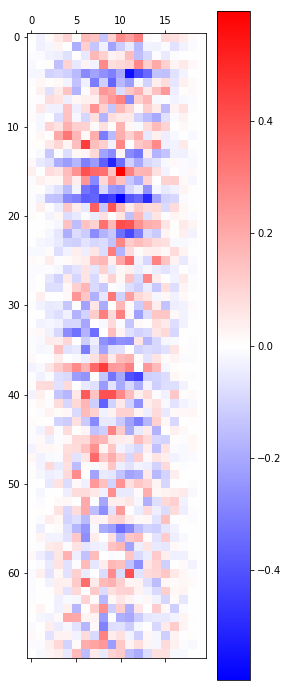

In [36]:
plt.matshow(NR_42[-1].T[:,0:20], cmap='bwr')
plt.colorbar()

In [37]:
filt_152 = np.zeros([980,256])
filt_152[0,152] = 1
NR_152 = get_NR_matrices(start=filt_152, startlayer=1)

(984, 256, 256)
(986, 256, 256)
(988, 256, 256)
(994, 256, 256)
(1000, 70, 256)


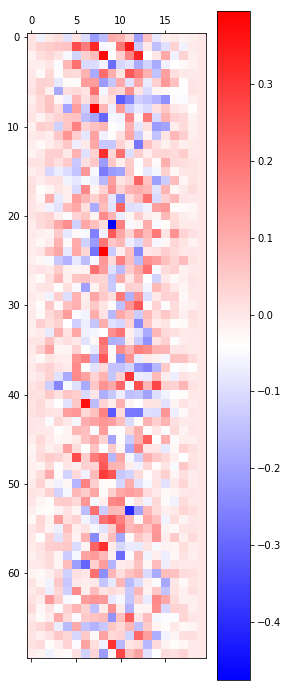

In [38]:
plt.matshow(NR_152[-1].T[:,0:20], cmap='bwr')
plt.colorbar()